In [1]:
##Importing the required libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive

##Libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

##Libraries for ensemble methods considered in the study
from xgboost import XGBRegressor

!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 29.4 MB/s eta 0:00:00


In [2]:
drive.mount('/content/gdrive')
data_path = '/content/gdrive/MyDrive/new_atlantis/'
random_seed = 216

Mounted at /content/gdrive


## Load Data

Data is for March 2021. Monthly averaged values.

In [17]:
data = pd.read_csv(data_path + 'obs_chl_pisces_plus_other_features_march_2021.csv')
data.shape

(569724, 20)

In [18]:
data.head()

,latitude,longitude,CHL,analysed_sst,sos,dos,fgco2,omega_ar,omega_ca,ph,spco2,talk,tco2,deptho,fe,no3,o2,nppv,po4,si
0,-75.5,-180.00,0.745324,271.756394,34.204094,1027.5248,1.587086,1.466226,2.338735,8.087303,351.45520,2321.0903,2194.7764,568.80536,0.000524,27.994402,326.66733,0.864997,2.000869,68.964560
1,-75.5,-179.75,0.685044,271.701994,34.193108,1027.5159,1.428289,1.458978,2.327192,8.085031,353.45938,2320.8772,2195.4310,573.67865,0.000505,27.846527,327.47052,0.872001,1.992910,68.159180
2,-75.5,-179.50,0.621697,271.648394,34.180702,1027.5059,1.288172,1.454097,2.319419,8.083524,354.78280,2320.6514,2195.7910,566.56550,0.000484,27.800156,327.06604,0.870575,1.990123,67.640710
3,-75.5,-179.25,0.579071,271.599594,34.173040,1027.4995,1.154647,1.447437,2.308806,8.081387,356.69434,2320.5276,2196.4705,565.98180,0.000495,27.945148,325.02423,0.865370,1.997842,67.783585
4,-75.5,-179.00,0.686786,271.568394,34.167526,1027.4952,1.018365,1.438670,2.294847,8.078671,359.11487,2320.2573,2197.2540,545.73870,0.000464,28.136585,322.88077,0.888784,2.004793,66.788376


In [19]:
data.columns[:3]

Index(['latitude', 'longitude', 'CHL'], dtype='object')

In [20]:
feature_names = data.columns[3:].tolist()

## XGBoost Regressor

Shap feature importance based on xgboost with default parameters

In [21]:
X = data.drop(columns=data.columns[:3].tolist()).values
y = data["CHL"].values

In [22]:
X.shape

(569724, 17)

In [23]:
# to store RMSE
cv_rmse = []
# to store SHAP values
cv_shap = []

kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print(i)
    start = time.time()
    # define the training set for the ith fold
    X_train = X[train_index,:]
    y_train = y[train_index]

    # define the validation set for the ith fold
    X_valid = X[valid_index,:]
    y_valid = y[valid_index]

    # xgb regressor
    xgbr = XGBRegressor(n_estimators = 500, random_state = 1,
                        early_stopping_rounds = 50, eval_metric = 'rmse',
                        tree_method='hist', device = 'cuda')
    xgbr.fit(X_train, y_train, eval_set = [(X_valid, y_valid)])

    # predict
    y_pred = xgbr.predict(X_valid)
    cv_rmse.append(mean_squared_error(y_valid,y_pred,squared=False))

    # shap importance
    explainer = shap.TreeExplainer(xgbr)
    shap_values = explainer.shap_values(X_valid)
    cv_shap.append(shap_values)

    del X_train, y_train, X_valid, y_valid, xgbr, y_pred, explainer, shap_values

    print('It takes %s minutes' % ((time.time() - start)/60))

0
[0]	validation_0-rmse:0.31910
[1]	validation_0-rmse:0.27036
[2]	validation_0-rmse:0.23673
[3]	validation_0-rmse:0.21420
[4]	validation_0-rmse:0.20045
[5]	validation_0-rmse:0.18979
[6]	validation_0-rmse:0.18225
[7]	validation_0-rmse:0.17584
[8]	validation_0-rmse:0.16955
[9]	validation_0-rmse:0.16707
[10]	validation_0-rmse:0.16301
[11]	validation_0-rmse:0.16121
[12]	validation_0-rmse:0.15979
[13]	validation_0-rmse:0.15847
[14]	validation_0-rmse:0.15659
[15]	validation_0-rmse:0.15454
[16]	validation_0-rmse:0.15311
[17]	validation_0-rmse:0.15012
[18]	validation_0-rmse:0.14789
[19]	validation_0-rmse:0.14596
[20]	validation_0-rmse:0.14511
[21]	validation_0-rmse:0.14413
[22]	validation_0-rmse:0.14260
[23]	validation_0-rmse:0.14185
[24]	validation_0-rmse:0.14121
[25]	validation_0-rmse:0.14031
[26]	validation_0-rmse:0.13899
[27]	validation_0-rmse:0.13777
[28]	validation_0-rmse:0.13709
[29]	validation_0-rmse:0.13682
[30]	validation_0-rmse:0.13634
[31]	validation_0-rmse:0.13526
[32]	validation_

In [24]:
cv_rmse

[0.0939890468996276,
 0.09427689373166123,
 0.0931076802903293,
 0.0939325281666755,
 0.0891258675724411]

In [25]:
# average over all the CV sets
shap_overall = np.mean(np.abs(cv_shap[0]), axis=0)
for i in range(1,5):
  shap_overall +=  np.mean(np.abs(cv_shap[i]), axis=0)

shap_overall /= 5

In [26]:
df = pd.DataFrame({'features':feature_names, 'shap':shap_overall})
df.head()

,features,shap
0,analysed_sst,0.043354
1,sos,0.026135
2,dos,0.030143
3,fgco2,0.022747
4,omega_ar,0.023090


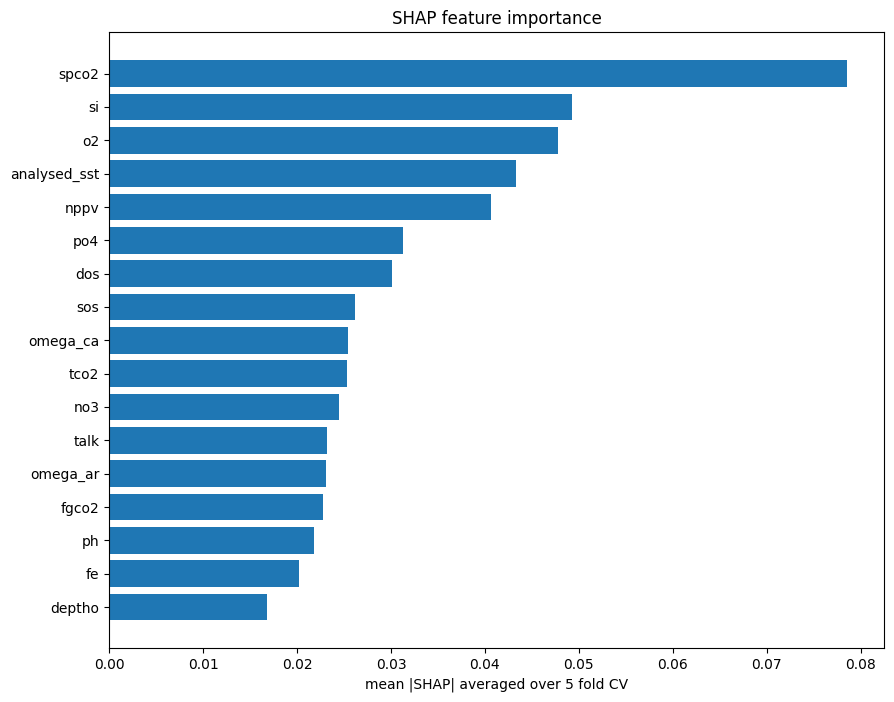

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))

temp = df.sort_values('shap', ascending=False)
f = temp.features.values
s = temp.shap.values

# Example data
y_pos = np.arange(len(f))

ax.barh(y_pos, s)
ax.set_yticks(y_pos, labels=f)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('mean |SHAP| averaged over 5 fold CV')
ax.set_title('SHAP feature importance')

plt.show()
